# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.

In [1]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import random

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-18 13:20:05.863242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 13:20:06.541113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training set, test set, and a test set with different distribution) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.

In [2]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).

In [3]:
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 1  # Duration of audio clips in seconds
N_FFT = 2048  # Window size for Short-Time Fourier Transform. 512 samples corresponds to ~32 ms at 16 kHz.
HOP_LENGTH = 512 # Step size for the STFT windows. A value of 256 (~50% overlap) ensures good temporal resolution.
MAX_LEN = 32000  # The target length of audio files in samples (2 seconds at 16 kHz = 32000 samples).
RANDOM_STATE = 2159081 # For reproducibility

random.seed(RANDOM_STATE)  # For reproducibility

# 2. Loading and balancing dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and splitted into two arrays for better reuse.

In [4]:
# Define a function to load labels and split filenames from the protocol file
def load_labels(file_path):
    bonafide_files = []
    spoof_files = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            if label == "bonafide":
                bonafide_files.append(filename)
            else:
                spoof_files.append(filename)
    return np.array(bonafide_files), np.array(spoof_files)

# Load training labels
train_bonafide_filenames, train_spoof_filenames = load_labels(LABELS_TRAIN)
test_bonafide_filenames, test_spoof_filenames = load_labels(LABELS_TEST)
test_unseen_bonafide_filenames, test_unseen_spoof_filenames = load_labels(LABELS_UNSEEN_TEST)

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))
print("Number of unseen test bonafide samples:", len(test_unseen_bonafide_filenames))
print("Number of unseen test spoof samples:", len(test_unseen_spoof_filenames))

Number of training bonafide samples: 2580
Number of training spoof samples: 22800
Number of test bonafide samples: 2548
Number of test spoof samples: 22296
Number of unseen test bonafide samples: 7355
Number of unseen test spoof samples: 63882


### Section 2.2: Reduce data for test speed

In [5]:
def shuffle_and_trim_list(input_list, n=10000):
    # List and shuffle
    random.shuffle(input_list)

    return input_list[:n]

# ATTENTION: Dataset limiting --------------------------------
train_spoof_filenames = shuffle_and_trim_list(train_spoof_filenames, n=10000)
test_spoof_filenames = shuffle_and_trim_list(test_spoof_filenames, n=10000)
test_unseen_spoof_filenames = shuffle_and_trim_list(test_unseen_spoof_filenames, n=10000)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))
print("Number of unseen test bonafide samples:", len(test_unseen_bonafide_filenames))
print("Number of unseen test spoof samples:", len(test_unseen_spoof_filenames))

Number of training bonafide samples: 2580
Number of training spoof samples: 10000
Number of test bonafide samples: 2548
Number of test spoof samples: 10000
Number of unseen test bonafide samples: 7355
Number of unseen test spoof samples: 10000


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and STFT Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to STFT format using `librosa`.
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [ ]:
import os
import librosa
import numpy as np
from tqdm import tqdm

# Load audio files with librosa, ensuring all are of the same length
def load_audio_files(dataset_path, file_list, sr=16000, max_len=32000):
    """
    Load audio files from a dataset path and ensure all are the same length with zero padding.
    
    Args:
        dataset_path (str): Path to the directory containing audio files.
        file_list (list): List of file names without extensions.
        sr (int): Sampling rate for librosa.load. Default is 16000.
        max_len (int): Target length for all audio signals (number of samples).
    
    Returns:
        np.array: Array of audio signals, all of the same length.
    """
    audio_data = []
    for filename in tqdm(file_list, desc="Loading audio files"):
        file_path = os.path.join(dataset_path, f"{filename}.flac")
        try:
            # Load the audio with the target sampling rate
            audio, _ = librosa.load(file_path, sr=sr, duration=max_len / sr)
            
            # Fix the length to max_len (zero padding or trimming as needed)
            audio = librosa.util.fix_length(audio, size=max_len)
            
            audio_data.append(audio)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return np.array(audio_data)

# Load the balanced dataset
audio_data_train_bonafide = load_audio_files(DATASET_TRAIN, train_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_train_spoof = load_audio_files(DATASET_TRAIN, train_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_test_bonafide = load_audio_files(DATASET_TEST, test_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_test_spoof = load_audio_files(DATASET_TEST, test_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_unseen_test_bonafide = load_audio_files(DATASET_UNSEEN_TEST, test_unseen_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_unseen_test_spoof = load_audio_files(DATASET_UNSEEN_TEST, test_unseen_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)


Loading audio files:  89%|██████████████████████████████████████████████████▌      | 6527/7355 [00:48<00:06, 129.10it/s]

# 6. Elaborazione dei dati audio con STFT

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Function to extract Short-Time Fourier Transform (STFT) features from audio files
def compute_stft(audio_files, n_fft=2048, hop_length=512):
    stft_features = []  # Initialize a list to store STFT features for each audio file.
    
    for audio in tqdm(audio_files, desc="Extracting STFT features"):
        # Compute the Short-Time Fourier Transform (STFT) of the audio signal.
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        
        # Compute the magnitude spectrogram by taking the absolute value of the STFT result.
        spectrogram = np.abs(stft)
        
        # Append the magnitude spectrogram to the features list.
        stft_features.append(spectrogram)
    
    # Convert the list of spectrograms to a NumPy array and return it.
    return np.array(stft_features)

# Compute STFT for all samples
stft_data_train_bonafide = compute_stft(audio_data_train_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_train_spoof = compute_stft(audio_data_train_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_test_bonafide = compute_stft(audio_data_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_test_spoof = compute_stft(audio_data_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_unseen_test_bonafide = compute_stft(stft_data_unseen_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_unseen_test_spoof = compute_stft(audio_data_unseen_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)

Extracting STFT features: 100%|██████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 234.87it/s]

# 7. Analisi e visualizzazione dei dati STFT

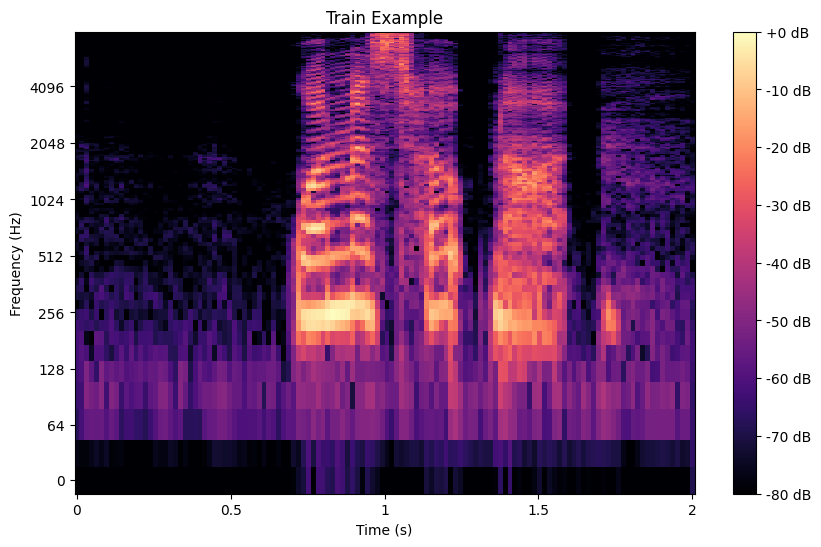

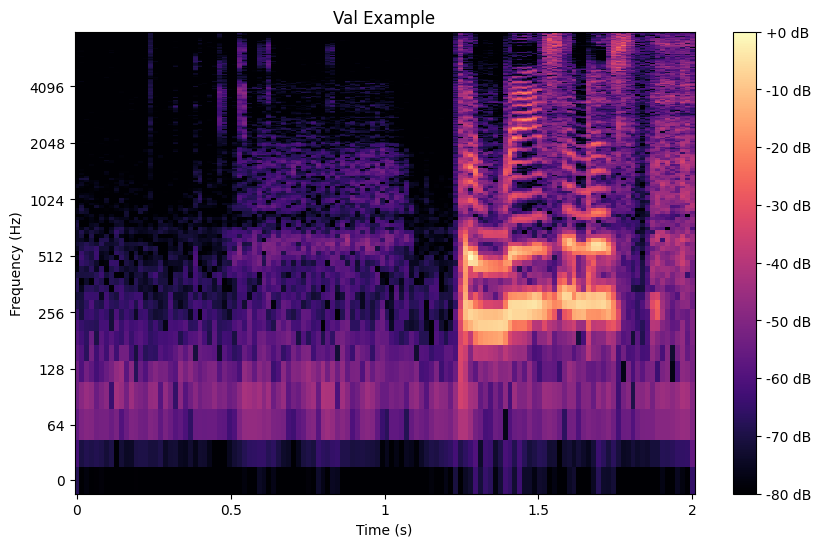

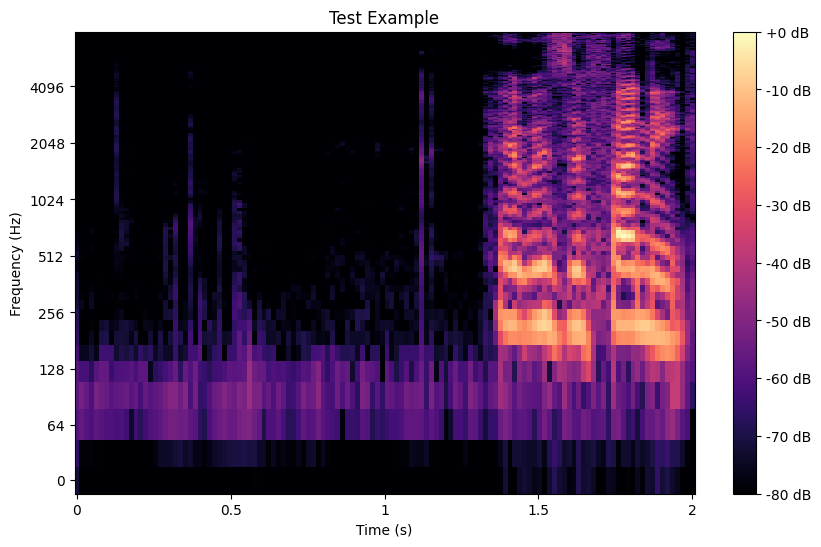

In [24]:
import random
import matplotlib.pyplot as plt

# Function to compute and visualize the spectrogram of an audio file
def plot_spectrogram(spectrogram, title, sr=22050, hop_length=512):
    """
    Plots the spectrogram of an audio signal using a logarithmic frequency scale.

    Parameters:
        spectrogram (ndarray): The STFT spectrogram of the audio signal (magnitude values).
        title (str): The title of the plot.
        sr (int, optional): Sampling rate of the audio signal. Default is 22050 Hz.
        hop_length (int, optional): Number of samples between successive frames in STFT. Default is 512.

    Returns:
        None
    """
    # Set up the figure for plotting
    plt.figure(figsize=(10, 6))
    
    # Display the spectrogram, converting amplitude values to decibels (dB)
    librosa.display.specshow(
        librosa.amplitude_to_db(spectrogram, ref=np.max),  # Convert amplitude to dB scale
        sr=sr,  # Sampling rate of the audio signal
        hop_length=hop_length,  # Hop length used in the STFT
        x_axis='time',  # Display time on the x-axis
        y_axis='log'    # Use a logarithmic scale for the frequency axis
    )
    
    # Add a color bar to indicate the dB scale
    plt.colorbar(format='%+2.0f dB')
    
    # Add plot title and axis labels
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Display the plot
    plt.show()

# Example usage of the spectrogram plotting function
# Retrieve the first spectrogram from the train normal dataset
train_normal_example = stft_data_train[0]  
plot_spectrogram(train_normal_example, "Train Example", sr=sr, hop_length=hop_length)

# Retrieve the first spectrogram from the val dataset
val_example = stft_data_val[0]  
plot_spectrogram(val_example, "Val Example", sr=sr, hop_length=hop_length)

# Retrieve the first spectrogram from the test normal dataset
test_normal_example = stft_data_test[0]  
plot_spectrogram(test_normal_example, "Test Example",  sr=sr, hop_length=hop_length)

# 8. Scaling dei dati audio con normalizzazione della durata
### Goal: mean = 0 and devstd = 1

In [25]:
'''
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to scale and normalize audio data
def scale_and_normalize_audio_data(audio_data, scaler, max_len=32000):
    scaled_audio_data = {}
    
    for filename, (audio, sr) in tqdm(audio_data.items(), desc="Scaling and normalizing audio data"):
        # Ensure audio length matches max_len
        if len(audio) > max_len:
            audio = audio[:max_len]
        elif len(audio) < max_len:
            audio = np.pad(audio, (0, max_len - len(audio)), 'constant')
        
        # Normalize audio values to have mean 0 and std 1
        audio = audio.reshape(-1, 1)  # Reshape for StandardScaler
        audio = scaler.fit_transform(audio).flatten()  # Use fit_transform here for training data
        
        scaled_audio_data[filename] = (audio, sr)
    
    return scaled_audio_data

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling and normalization to audio data
scaled_audio_data = scale_and_normalize_audio_data(audio_data, scaler, max_len=max_len)

# Example check: print statistics of a scaled and normalized sample
example_filename = next(iter(scaled_audio_data))
example_audio_scaled, example_sr_scaled = scaled_audio_data[example_filename]
example_audio, example_sr = audio_data[example_filename]
print(f"Sample: {example_filename}")
print(f"Length: {len(example_audio)} (expected: {max_len})")
print(f"Mean: {np.mean(example_audio):.2f}, Std: {np.std(example_audio):.2f}")
print(f"Length of scaled file: {len(example_audio_scaled)} (expected: {max_len})")
print(f"Mean of scaled file: {np.mean(example_audio_scaled):.2f}, Std of scaled file: {np.std(example_audio_scaled):.2f}")
'''
# Dtaa transformation: transpose the vector in order to have the correct shape for the autoencoder
print(stft_data_train.shape)
print(stft_data_val.shape)
print(stft_data_test.shape)

stft_data_train = stft_data_train.transpose(0, 2, 1)
stft_data_val = stft_data_val.transpose(0, 2, 1)
stft_data_test = stft_data_test.transpose(0, 2, 1)

print(stft_data_train.shape)
print(stft_data_val.shape)
print(stft_data_test.shape)

(500, 257, 126)
(500, 257, 126)
(500, 257, 126)
(500, 126, 257)
(500, 126, 257)
(500, 126, 257)


In [26]:
# Data normalizzation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
stft_data_train_scaled = scaler.fit_transform(stft_data_train.reshape(-1, stft_data_train.shape[-1])).reshape(stft_data_train.shape)
stft_data_val_scaled = scaler.transform(stft_data_val.reshape(-1, stft_data_val.shape[-1])).reshape(stft_data_val.shape)
stft_data_test_scaled = scaler.transform(stft_data_test.reshape(-1, stft_data_test.shape[-1])).reshape(stft_data_test.shape)

print(stft_data_train_scaled.shape)
print(stft_data_val_scaled.shape)
print(stft_data_test_scaled.shape)

(500, 126, 257)
(500, 126, 257)
(500, 126, 257)


# 9. Preparazione dei dataset di validation e test con shuffle e limitazione

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input dimensions
time_steps = 126  # Number of time frames
n_stft = 257     # Number of STFT coefficients (frequency bins)
latent_dim = 64   # Dimension of the latent space for compressed representation

# Encoder
encoder_inputs = tf.keras.Input(shape=(time_steps, n_stft))  # Input layer with shape (time_steps, n_stft)
encoded = layers.LSTM(128, return_sequences=True)(encoder_inputs)  # First LSTM layer with 128 units, returning sequences
encoded = layers.LSTM(latent_dim, return_sequences=False)(encoded)  # Second LSTM layer reducing to latent_dim, without returning sequences

# Decoder
decoded = layers.RepeatVector(time_steps)(encoded)  # Repeat latent vector for each time step
decoded = layers.LSTM(128, return_sequences=True)(decoded)  # LSTM layer reconstructing intermediate sequences
decoded = layers.LSTM(n_stft, return_sequences=True)(decoded)  # Final LSTM layer reconstructing original dimensions

# Autoencoder
autoencoder_sftf = models.Model(encoder_inputs, decoded, name="Recurrent_Autoencoder")  # Full autoencoder model

# Encoder model for extracting latent representations
latent_model_sftf = models.Model(encoder_inputs, encoded, name="Encoder")  # Encoder model to extract latent space

# Compile the autoencoder
autoencoder_sftf.compile(optimizer='adam', loss='mse')  # Use Mean Squared Error (MSE) as the loss function

# Display model summaries
autoencoder_sftf.summary()  # Summary of the autoencoder architecture
latent_model_sftf.summary()  # Summary of the encoder architecture

2025-01-17 12:29:24.502710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 12:29:24.899543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Recurrent_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 126, 257)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 126, 128)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 126, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 126, 257)       │       396,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 742,664 (2.83 MB)

 Trainable params: 742,664 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 126, 257)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 126, 128)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,040 (965.00 KB)

 Trainable params: 247,040 (965.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Data training
autoencoder_sftf.fit(
    stft_data_train_scaled,
    stft_data_train_scaled,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5


2025-01-17 12:29:54.611730: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 9.9027e-04 - val_loss: 0.0013


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


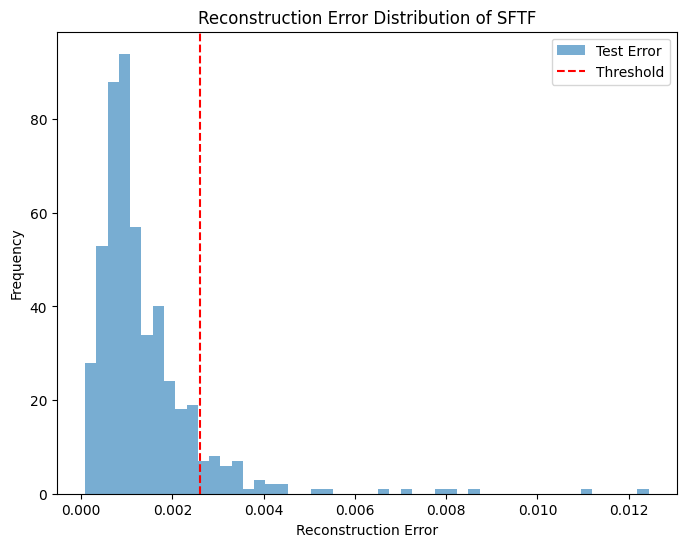

In [31]:
# Use the autoencoder to reconstruct the test and anomaly datasets
reconstructed_test = autoencoder_sftf.predict(stft_data_test_scaled)

# Calculate Mean Squared Error (MSE) for reconstruction loss
test_loss = np.mean(np.square(stft_data_test_scaled - reconstructed_test), axis=(1, 2))

import matplotlib.pyplot as plt

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(test_loss, bins=50, alpha=0.6, label='Test Error')
# here we define a simple and dummy threshold
plt.axvline(np.mean(test_loss) + 1 * np.std(test_loss), color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution of SFTF")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [32]:
# Predict the latent space for the train, test and anomaly dataset
train_sftf_latent = latent_model_sftf.predict(stft_data_train_scaled)
test_sftf_latent = latent_model_sftf.predict(stft_data_test_scaled)

print(train_sftf_latent.shape)
print(test_sftf_latent.shape)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(500, 64)
(500, 64)
